# Ungraded Lab: Using a multi-layer LSTM for forecasting

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Sequences_Time_Series_and_Prediction/Week3/Labs/C4_W3_Lab_2_LSTM.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this lab, you will use the same RNN architecure in the first lab but will instead stack [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers instead of `SimpleRNN`.

## Imports

In [1]:
import tensorflow as tf
from keras import Sequential, Input, layers, callbacks, optimizers, losses, metrics, backend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2024-06-14 11:44:01.013110: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
        time (array of int) - contains the time steps
        series (array of int) - contains the measurements for each time step
        format - line style when plotting the graph
        start - first time step to plot
        end - last time step to plot
    """
    sns.set_style("whitegrid")

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
        # Plot the time series data
        plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
        time (array of int) - contains the time steps
        slope (float) - determines the direction and steepness of the line

    Returns:
        series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
        season_time (array of float) - contains the measurements per time step

    Returns:
        data_pattern (array of float) -  contains revised measurement values according to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                            np.cos(season_time * 2 * np.pi),
                            1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
        time (array of int) - contains the time steps
        period (int) - number of time steps before the pattern repeats
        amplitude (int) - peak measured value in a period
        phase (int) - number of time steps to shift the measured values

    Returns:
        data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
        time (array of int) - contains the time steps
        noise_level (float) - scaling factor for the generated signal
        seed (int) - number generator seed for repeatability

    Returns:
        noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the Synthetic Data

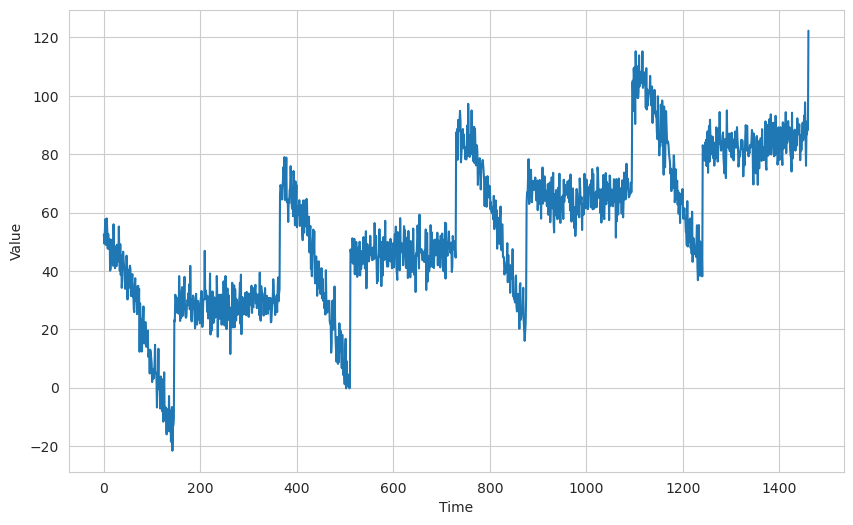

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
        series (array of float) - contains the values of the time series
        window_size (int) - the number of time steps to include in the feature
        batch_size (int) - the batch size
        shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
        dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-06-14 11:44:04.560485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2148 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## Build the Model

As mentioned, you will swap `SimpleRNN` for `LSTM` in this lab. It is also set as bidirectional below but feel free to revise later and see what results you get. LSTMs are much more complex in their internal architecture than simpleRNNs. It implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and you'll see that when you print the model summary below.

In [8]:
# Build the Model
model_tune = Sequential([Input(shape=(window_size,)),
                         layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
                         layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
                         layers.Bidirectional(layers.LSTM(32)),
                         layers.Dense(1),
                         layers.Lambda(lambda x: x * 100.0)])

# Print the model summary
model_tune.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

As usual, you will pick a learning rate by running the tuning code below.

In [9]:
# Set the learning rate scheduler
lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2024-06-14 11:44:07.360838: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 58.0261 - learning_rate: 1.0000e-08
Epoch 2/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 57.2106

2024-06-14 11:44:08.623988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:08.624025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:08.624052: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:08.624060: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:08.624090: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
/home/luis-mendoza/anaconda3/envs/TDPC_env/lib/python3.11/contextlib.py:158: UserWarning: Your input ran ou

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 57.3441 - learning_rate: 1.1220e-08
Epoch 3/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 55.0942  

2024-06-14 11:44:08.913537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:08.913580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 55.8074 - learning_rate: 1.2589e-08
Epoch 4/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 57.4527

2024-06-14 11:44:09.244128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:09.244166: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:09.244174: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:09.244208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 56.2387 - learning_rate: 1.4125e-08
Epoch 5/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 55.0798

2024-06-14 11:44:09.525386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:09.525421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 54.0906 - learning_rate: 1.5849e-08
Epoch 6/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 52.7687

2024-06-14 11:44:09.805831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:09.805861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:09.805886: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:09.805896: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:09.805931: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 52.2076 - learning_rate: 1.7783e-08
Epoch 7/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 49.7519

2024-06-14 11:44:10.089662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:10.089697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:10.089724: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:10.089736: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:10.089752: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 49.7018 - learning_rate: 1.9953e-08
Epoch 8/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 48.1416

2024-06-14 11:44:10.369654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:10.369715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 47.8808 - learning_rate: 2.2387e-08
Epoch 9/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 45.9104

2024-06-14 11:44:10.652008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:10.652042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:10.652068: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:10.652076: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:10.652112: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 45.5270 - learning_rate: 2.5119e-08
Epoch 10/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 42.8039

2024-06-14 11:44:10.935030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:10.935062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:10.935084: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:10.935093: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:10.935102: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 42.6170 - learning_rate: 2.8184e-08
Epoch 11/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 39.3510

2024-06-14 11:44:11.218564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:11.218593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:11.218618: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:11.218626: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:11.218663: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 39.5930 - learning_rate: 3.1623e-08
Epoch 12/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 38.3617

2024-06-14 11:44:11.498278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:11.498316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 37.7327 - learning_rate: 3.5481e-08
Epoch 13/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 34.5759

2024-06-14 11:44:11.813161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:11.813232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 33.8752 - learning_rate: 3.9811e-08
Epoch 14/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 29.9905

2024-06-14 11:44:12.109040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:12.109076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 29.4439 - learning_rate: 4.4668e-08
Epoch 15/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28.0390

2024-06-14 11:44:12.393189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:12.393227: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:12.393236: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:12.393242: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:12.393257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 26.6912 - learning_rate: 5.0119e-08
Epoch 16/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 21.5811

2024-06-14 11:44:12.672654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:12.672689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:44:12.672714: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.9637 - learning_rate: 5.6234e-08
Epoch 17/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17.4024

2024-06-14 11:44:12.961964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:12.961997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:12.962022: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:12.962031: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:12.962068: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16.6736 - learning_rate: 6.3096e-08
Epoch 18/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.7220

2024-06-14 11:44:13.243482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:13.243528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:13.243541: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:13.243548: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:13.243557: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.7149 - learning_rate: 7.0795e-08
Epoch 19/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.6534

2024-06-14 11:44:13.526109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:13.526143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:13.526157: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:13.526168: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:13.526178: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.6550 - learning_rate: 7.9433e-08
Epoch 20/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.3545

2024-06-14 11:44:13.806809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:13.806886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.6986 - learning_rate: 8.9125e-08
Epoch 21/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.9673

2024-06-14 11:44:14.086861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:14.086893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:14.086919: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:14.086929: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:14.086956: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.8626 - learning_rate: 1.0000e-07
Epoch 22/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.5931

2024-06-14 11:44:14.406770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:14.406806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.0634 - learning_rate: 1.1220e-07
Epoch 23/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.7261

2024-06-14 11:44:14.688371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:14.688408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:14.688434: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:14.688492: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:14.688519: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.3741 - learning_rate: 1.2589e-07
Epoch 24/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6762 

2024-06-14 11:44:14.974952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:14.974985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:14.974997: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:14.975004: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:14.975021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6675 - learning_rate: 1.4125e-07
Epoch 25/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.3145

2024-06-14 11:44:15.261536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:15.261566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:15.261597: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:15.261609: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:15.261643: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6646 - learning_rate: 1.5849e-07
Epoch 26/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5212

2024-06-14 11:44:15.542791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:15.542820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:15.542845: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:15.542854: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:15.542891: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5191 - learning_rate: 1.7783e-07
Epoch 27/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.3035

2024-06-14 11:44:15.819733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:15.819811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2669 - learning_rate: 1.9953e-07
Epoch 28/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3811

2024-06-14 11:44:16.096683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:16.096723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:16.096740: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:16.096752: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:16.096764: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1465 - learning_rate: 2.2387e-07
Epoch 29/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8690

2024-06-14 11:44:16.369084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:16.369121: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:16.369130: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:16.369136: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:16.369153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8179 - learning_rate: 2.5119e-07
Epoch 30/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2245

2024-06-14 11:44:16.651478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:16.651530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2504 - learning_rate: 2.8184e-07
Epoch 31/100


2024-06-14 11:44:16.930237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:16.930277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:16.930294: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:16.930307: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:16.930320: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1458 - learning_rate: 3.1623e-07
Epoch 32/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7044

2024-06-14 11:44:17.568268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:17.568296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:17.568322: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:17.568330: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:17.568369: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8075 - learning_rate: 3.5481e-07
Epoch 33/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9503

2024-06-14 11:44:17.847676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:17.847711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:17.847737: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:17.847745: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:17.847773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7697 - learning_rate: 3.9811e-07
Epoch 34/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3681

2024-06-14 11:44:18.125556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:18.125631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.5383 - learning_rate: 4.4668e-07
Epoch 35/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2901

2024-06-14 11:44:18.400554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:18.400591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:18.400604: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:18.400611: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:18.400619: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4409 - learning_rate: 5.0119e-07
Epoch 36/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.5853

2024-06-14 11:44:18.680282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:18.680313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:18.680337: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:18.680351: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:18.680363: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.5631 - learning_rate: 5.6234e-07
Epoch 37/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3236

2024-06-14 11:44:18.957899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:18.957980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3950 - learning_rate: 6.3096e-07
Epoch 38/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6396

2024-06-14 11:44:19.236023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:19.236057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:19.236070: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:19.236077: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:19.236085: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.5439 - learning_rate: 7.0795e-07
Epoch 39/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3988

2024-06-14 11:44:19.512899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:19.512929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:19.512954: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:19.512962: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:19.513001: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4135 - learning_rate: 7.9433e-07
Epoch 40/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9485

2024-06-14 11:44:19.794098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:19.794129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:19.794153: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:19.794161: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:19.794191: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0389 - learning_rate: 8.9125e-07
Epoch 41/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2759

2024-06-14 11:44:20.109425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:20.109459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2087 - learning_rate: 1.0000e-06
Epoch 42/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2928

2024-06-14 11:44:20.387490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:20.387539: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:20.387548: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:20.387554: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:20.387577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2353 - learning_rate: 1.1220e-06
Epoch 43/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9252

2024-06-14 11:44:20.667780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:20.667814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:20.667845: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:20.667858: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:20.667881: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9936 - learning_rate: 1.2589e-06
Epoch 44/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1160

2024-06-14 11:44:20.946867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:20.946904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:20.946929: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:20.946939: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:20.946969: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0661 - learning_rate: 1.4125e-06
Epoch 45/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7024

2024-06-14 11:44:21.223404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:21.223438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8191 - learning_rate: 1.5849e-06
Epoch 46/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9844

2024-06-14 11:44:21.501803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:21.501838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9391 - learning_rate: 1.7783e-06
Epoch 47/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0566

2024-06-14 11:44:21.785663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:21.785737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9758 - learning_rate: 1.9953e-06
Epoch 48/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6100

2024-06-14 11:44:22.071521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:22.071556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7063 - learning_rate: 2.2387e-06
Epoch 49/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4347

2024-06-14 11:44:22.357245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:22.357280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:22.357306: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:22.357314: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:22.357349: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5605 - learning_rate: 2.5119e-06
Epoch 50/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5464

2024-06-14 11:44:22.668317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:22.668351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:22.668377: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:22.668386: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:22.668413: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6390 - learning_rate: 2.8184e-06
Epoch 51/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6550

2024-06-14 11:44:22.948228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:22.948264: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:22.948273: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:22.948280: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:22.948306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6034 - learning_rate: 3.1623e-06
Epoch 52/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8809

2024-06-14 11:44:23.229962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:23.229997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:23.230021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:23.230040: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:23.230053: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6793 - learning_rate: 3.5481e-06
Epoch 53/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4685

2024-06-14 11:44:23.508913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:23.508952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4538 - learning_rate: 3.9811e-06
Epoch 54/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8350

2024-06-14 11:44:23.786603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:23.786636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:23.786649: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:23.786656: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:23.786664: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0115 - learning_rate: 4.4668e-06
Epoch 55/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8740

2024-06-14 11:44:24.064105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:24.064141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:24.064171: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:24.064184: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:24.064200: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0468 - learning_rate: 5.0119e-06
Epoch 56/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6173

2024-06-14 11:44:24.341061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:24.341104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4507 - learning_rate: 5.6234e-06
Epoch 57/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1214

2024-06-14 11:44:24.622022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:24.622095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1071 - learning_rate: 6.3096e-06
Epoch 58/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2224

2024-06-14 11:44:24.902775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:24.902811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:24.902837: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:24.902844: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:24.902873: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1782 - learning_rate: 7.0795e-06
Epoch 59/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8695

2024-06-14 11:44:25.218272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:25.218309: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:25.218321: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:25.218330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:25.218394: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9189 - learning_rate: 7.9433e-06
Epoch 60/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9793

2024-06-14 11:44:25.498068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:25.498109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0224 - learning_rate: 8.9125e-06
Epoch 61/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2790

2024-06-14 11:44:25.775873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:25.775906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:25.775932: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:25.775940: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:25.775976: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2062 - learning_rate: 1.0000e-05
Epoch 62/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9398

2024-06-14 11:44:26.060535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:26.060574: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:26.060583: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:26.060590: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:26.060602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9405 - learning_rate: 1.1220e-05
Epoch 63/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1144

2024-06-14 11:44:26.340210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:26.340256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:26.340287: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:26.340310: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:26.340330: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0591 - learning_rate: 1.2589e-05
Epoch 64/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9053

2024-06-14 11:44:26.616891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:26.616929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8510 - learning_rate: 1.4125e-05
Epoch 65/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1882

2024-06-14 11:44:26.894503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:26.894536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3603 - learning_rate: 1.5849e-05
Epoch 66/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.5507

2024-06-14 11:44:27.183899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:27.183929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:27.183955: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:27.183965: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:27.183981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3715 - learning_rate: 1.7783e-05
Epoch 67/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7963 

2024-06-14 11:44:27.468376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:27.468414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:27.468439: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:27.468505: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:27.468534: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3822 - learning_rate: 1.9953e-05
Epoch 68/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2590

2024-06-14 11:44:27.779167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:27.779196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:27.779220: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:27.779237: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:27.779250: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2404 - learning_rate: 2.2387e-05
Epoch 69/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1302

2024-06-14 11:44:28.056643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:28.056684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.1688 - learning_rate: 2.5119e-05
Epoch 70/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4254

2024-06-14 11:44:28.330308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:28.330342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:28.330354: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:28.330361: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:28.330369: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4888 - learning_rate: 2.8184e-05
Epoch 71/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9372

2024-06-14 11:44:28.609736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:28.609768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:28.609794: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:28.609812: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:28.609825: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0580 - learning_rate: 3.1623e-05
Epoch 72/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0373

2024-06-14 11:44:28.888319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:28.888392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6870 - learning_rate: 3.5481e-05
Epoch 73/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1071

2024-06-14 11:44:29.169710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:29.169752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1027 - learning_rate: 3.9811e-05
Epoch 74/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0505

2024-06-14 11:44:29.450375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:29.450414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:29.450443: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:29.450459: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0736 - learning_rate: 4.4668e-05
Epoch 75/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8448

2024-06-14 11:44:29.734631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:29.734667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:29.734690: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:29.734701: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:29.734711: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8905 - learning_rate: 5.0119e-05
Epoch 76/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9932

2024-06-14 11:44:30.013045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:30.013087: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:30.013097: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:30.013104: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:30.013112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3082 - learning_rate: 5.6234e-05
Epoch 77/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1381  

2024-06-14 11:44:30.294888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:30.294922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:30.294948: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:30.295003: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:30.295027: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3807 - learning_rate: 6.3096e-05
Epoch 78/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9797

2024-06-14 11:44:30.612906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:30.612944: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:30.612980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0013 - learning_rate: 7.0795e-05
Epoch 79/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4272

2024-06-14 11:44:30.891133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:30.891172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9561 - learning_rate: 7.9433e-05
Epoch 80/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5883 

2024-06-14 11:44:31.173579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:31.173616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:31.173642: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:31.173703: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:31.173732: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0747 - learning_rate: 8.9125e-05
Epoch 81/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6713

2024-06-14 11:44:31.453477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:31.453512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:31.453538: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:31.453547: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:31.453579: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4795 - learning_rate: 1.0000e-04
Epoch 82/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6036

2024-06-14 11:44:31.729625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:31.729696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0804 - learning_rate: 1.1220e-04
Epoch 83/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1812

2024-06-14 11:44:32.010004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:32.010036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:32.010053: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:32.010064: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:32.010076: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.4142 - learning_rate: 1.2589e-04
Epoch 84/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4964

2024-06-14 11:44:32.302249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:32.302282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:32.302306: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:32.302314: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:32.302341: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.1855 - learning_rate: 1.4125e-04
Epoch 85/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8281

2024-06-14 11:44:32.578479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:32.578521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6363 - learning_rate: 1.5849e-04
Epoch 86/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.7513

2024-06-14 11:44:32.894966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:32.894996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:32.895021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:32.895039: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:32.895051: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.4422 - learning_rate: 1.7783e-04
Epoch 87/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.7572 

2024-06-14 11:44:33.174604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:33.174675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9392 - learning_rate: 1.9953e-04
Epoch 88/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0240

2024-06-14 11:44:33.456900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:33.456934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:33.456959: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:33.456968: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:33.456998: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0825 - learning_rate: 2.2387e-04
Epoch 89/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1422

2024-06-14 11:44:33.738900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:33.738935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:33.738961: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:33.738969: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:33.739002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8804 - learning_rate: 2.5119e-04
Epoch 90/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.5843 

2024-06-14 11:44:34.023636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:34.023672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:34.023698: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:34.023706: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:34.023743: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.1717 - learning_rate: 2.8184e-04
Epoch 91/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8268

2024-06-14 11:44:34.307128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:44:34.307161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:34.307184: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0708 - learning_rate: 3.1623e-04
Epoch 92/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2211

2024-06-14 11:44:34.590058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:34.590128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6605 - learning_rate: 3.5481e-04
Epoch 93/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.0907

2024-06-14 11:44:34.869280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_17]]
2024-06-14 11:44:34.869318: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:34.869331: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 2062232037716273100
2024-06-14 11:44:34.869343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:34.869366: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:34.869383: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item c

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.5780 - learning_rate: 3.9811e-04
Epoch 94/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6214

2024-06-14 11:44:35.149180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:35.149348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1777 - learning_rate: 4.4668e-04
Epoch 95/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.5253

2024-06-14 11:44:35.469179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:35.469213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:35.469243: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:35.469256: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:35.469276: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.3955 - learning_rate: 5.0119e-04
Epoch 96/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.5967

2024-06-14 11:44:35.746014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:35.746050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:35.746075: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:35.746084: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:35.746118: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.6608 - learning_rate: 5.6234e-04
Epoch 97/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.2505

2024-06-14 11:44:36.029453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:36.029485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:36.029510: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:36.029528: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:36.029541: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.1490 - learning_rate: 6.3096e-04
Epoch 98/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6412

2024-06-14 11:44:36.310514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:36.310587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.4091 - learning_rate: 7.0795e-04
Epoch 99/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.2388

2024-06-14 11:44:36.592362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:36.592394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:36.592419: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:36.592429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:36.592442: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.6238 - learning_rate: 7.9433e-04
Epoch 100/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.7702

2024-06-14 11:44:36.872260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:36.872304: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458
2024-06-14 11:44:36.872314: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:36.872321: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:36.872345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.2852 - learning_rate: 8.9125e-04


2024-06-14 11:44:37.160741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:37.160777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_15]]
2024-06-14 11:44:37.160802: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:37.160811: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17316532355039342527
2024-06-14 11:44:37.160847: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 987587937410089458


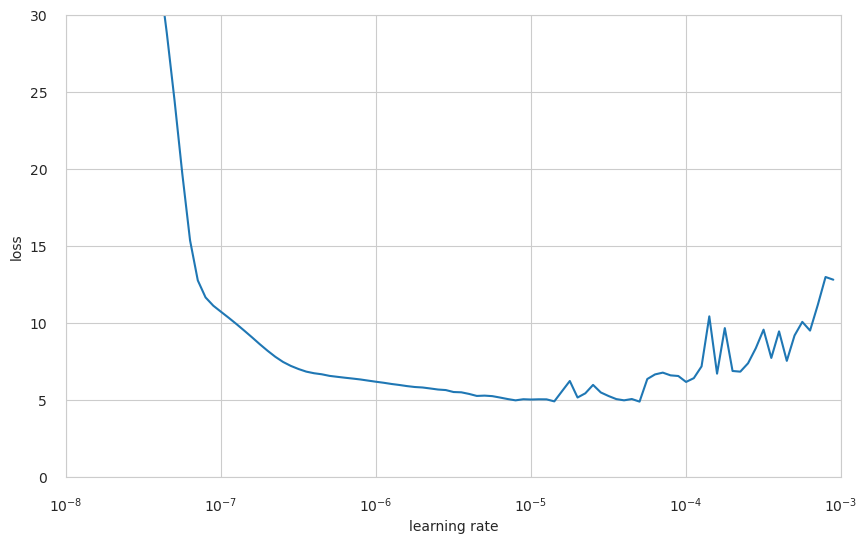

In [10]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

plt.xlabel("learning rate")
plt.ylabel("loss")
plt.show()

## Train the Model

You can then proceed to train the model with your chosen learning rate.

*Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the [`clear_session()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) method to declutter memory used by Keras. This is added in the first line below.*


In [11]:
# Reset states generated by Keras
backend.clear_session()

# Build the model
model = Sequential([Input(shape=(None,)),
                    layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
                    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
                    layers.Bidirectional(layers.LSTM(32)),
                    layers.Dense(1),
                    layers.Lambda(lambda x: x * 100.0)])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 38.2782 - mae: 38.7771
Epoch 2/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.6298 - mae: 16.1223

2024-06-14 11:44:40.844379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:40.844429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:44:40.844443: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:40.844454: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:40.844471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.7945 - mae: 15.2867
Epoch 3/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9844 - mae: 10.4727 

2024-06-14 11:44:41.142017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:41.142096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.5950 - mae: 10.0830
Epoch 4/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.6068 - mae: 8.0860

2024-06-14 11:44:41.432547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:41.432586: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:41.432671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.4272 - mae: 7.9074
Epoch 5/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9352 - mae: 7.4219

2024-06-14 11:44:41.721835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:41.721870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6963 - mae: 7.1810
Epoch 6/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9183 - mae: 6.3990

2024-06-14 11:44:42.012994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:42.013027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:42.013054: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:42.013065: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:42.013077: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9343 - mae: 6.4149
Epoch 7/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6325 - mae: 7.1118

2024-06-14 11:44:42.308114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:42.308155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:42.308171: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:42.308182: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:42.308195: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2602 - mae: 6.7392
Epoch 8/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8659 - mae: 6.3402

2024-06-14 11:44:42.601372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:42.601405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:42.601418: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:42.601426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:42.601434: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8530 - mae: 6.3294
Epoch 9/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7988 - mae: 6.2654

2024-06-14 11:44:42.924965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:42.925005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7566 - mae: 6.2270
Epoch 10/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3044 - mae: 5.7858

2024-06-14 11:44:43.215804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:43.215842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4945 - mae: 5.9745
Epoch 11/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1750 - mae: 5.6538

2024-06-14 11:44:43.505331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:43.505368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3289 - mae: 5.8078
Epoch 12/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6060 - mae: 6.0904

2024-06-14 11:44:43.798085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:43.798121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:43.798189: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:43.798215: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5278 - mae: 6.0108
Epoch 13/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4028 - mae: 5.8905

2024-06-14 11:44:44.090971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:44.091041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4413 - mae: 5.9261
Epoch 14/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0497 - mae: 6.5253

2024-06-14 11:44:44.382133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:44.382174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:44.382192: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:44.382203: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:44.382217: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8393 - mae: 6.3167
Epoch 15/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6080 - mae: 6.0869

2024-06-14 11:44:44.671934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:44.671970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4901 - mae: 5.9686
Epoch 16/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3662 - mae: 5.8453

2024-06-14 11:44:44.964025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:44.964103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3606 - mae: 5.8391
Epoch 17/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1359 - mae: 5.6138

2024-06-14 11:44:45.255561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:45.255596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2364 - mae: 5.7147
Epoch 18/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9296 - mae: 6.4060

2024-06-14 11:44:45.544111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:45.544153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5203 - mae: 5.9928
Epoch 19/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6039 - mae: 6.0809

2024-06-14 11:44:45.864986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:45.865019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:45.865031: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:45.865038: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:45.865048: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4629 - mae: 5.9404
Epoch 20/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3432 - mae: 5.8251

2024-06-14 11:44:46.152222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:46.152258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:44:46.152284: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:44:46.152299: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:46.152314: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2460 - mae: 5.7251
Epoch 21/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4044 - mae: 5.8838

2024-06-14 11:44:46.446739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:46.446784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3059 - mae: 5.7852
Epoch 22/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3931 - mae: 5.8701

2024-06-14 11:44:46.738816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:46.738882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2865 - mae: 5.7626
Epoch 23/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9964 - mae: 5.4724

2024-06-14 11:44:47.033782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:44:47.033914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0420 - mae: 5.5186
Epoch 24/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1558 - mae: 5.6356

2024-06-14 11:44:47.329722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:47.329768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1433 - mae: 5.6225
Epoch 25/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9651 - mae: 5.4411

2024-06-14 11:44:47.621356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:47.621395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0023 - mae: 5.4791
Epoch 26/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8267 - mae: 5.3013

2024-06-14 11:44:47.908543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:47.908577: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:44:47.908588: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:47.908597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:44:47.908621: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8958 - mae: 5.3713
Epoch 27/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5768 - mae: 5.0569

2024-06-14 11:44:48.194965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:48.195011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7112 - mae: 5.1907
Epoch 28/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7598 - mae: 5.2312

2024-06-14 11:44:48.525140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:48.525174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:48.525186: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:48.525193: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:48.525201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8736 - mae: 5.3474
Epoch 29/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1778 - mae: 5.6557

2024-06-14 11:44:48.809513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:48.809548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:48.809609: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:48.809635: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0341 - mae: 5.5112
Epoch 30/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0374 - mae: 5.5192

2024-06-14 11:44:49.094372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:49.094407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:44:49.094431: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:49.094440: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:49.094466: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0191 - mae: 5.4990
Epoch 31/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9767 - mae: 5.4619

2024-06-14 11:44:49.381192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:49.381282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9458 - mae: 5.4282
Epoch 32/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9537 - mae: 5.4320

2024-06-14 11:44:49.669277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:49.669311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:49.669324: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:49.669332: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:49.669340: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9421 - mae: 5.4198
Epoch 33/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0709 - mae: 5.5473

2024-06-14 11:44:49.953651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:49.953686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:49.953745: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:49.953775: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9415 - mae: 5.4171
Epoch 34/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1397 - mae: 5.6179

2024-06-14 11:44:50.238517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:50.238595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0631 - mae: 5.5413
Epoch 35/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7786 - mae: 5.2583

2024-06-14 11:44:50.519606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:50.519643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7687 - mae: 5.2476
Epoch 36/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0386 - mae: 5.5196

2024-06-14 11:44:50.806575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:50.806610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:44:50.806633: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:44:50.806653: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:50.806667: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9487 - mae: 5.4289
Epoch 37/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9248 - mae: 5.4079

2024-06-14 11:44:51.095032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:51.095065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8491 - mae: 5.3309
Epoch 38/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4352 - mae: 5.9089

2024-06-14 11:44:51.415653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:51.415720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1818 - mae: 5.6556
Epoch 39/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6470 - mae: 5.1232

2024-06-14 11:44:51.701535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:51.701575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:51.701593: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:51.701604: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:51.701617: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6928 - mae: 5.1686
Epoch 40/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5097 - mae: 4.9850

2024-06-14 11:44:51.988489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:51.988559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6048 - mae: 5.0808
Epoch 41/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9592 - mae: 5.4388

2024-06-14 11:44:52.283123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:52.283166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8490 - mae: 5.3271
Epoch 42/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5753 - mae: 5.0511

2024-06-14 11:44:52.567538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:52.567607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6218 - mae: 5.0981
Epoch 43/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3691 - mae: 4.8406

2024-06-14 11:44:52.851036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:52.851115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4875 - mae: 4.9617
Epoch 44/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4313 - mae: 4.9078

2024-06-14 11:44:53.138301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:53.138334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5646 - mae: 5.0409
Epoch 45/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4413 - mae: 5.9235

2024-06-14 11:44:53.425492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:53.425558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1275 - mae: 5.6082
Epoch 46/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9110 - mae: 5.3928

2024-06-14 11:44:53.710217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:53.710252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8267 - mae: 5.3068
Epoch 47/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8875 - mae: 5.3660

2024-06-14 11:44:54.029139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:54.029176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:54.029202: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:54.029213: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8273 - mae: 5.3038
Epoch 48/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6592 - mae: 5.1353

2024-06-14 11:44:54.311862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:54.311900: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:44:54.311909: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:54.311916: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:54.311940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7056 - mae: 5.1806
Epoch 49/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4966 - mae: 4.9710

2024-06-14 11:44:54.595835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:54.595873: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:44:54.595881: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:54.595888: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:54.595908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5634 - mae: 5.0383
Epoch 50/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7207 - mae: 5.1949

2024-06-14 11:44:54.883940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:54.883977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:54.884037: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:54.884063: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6760 - mae: 5.1509
Epoch 51/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1551 - mae: 5.6390

2024-06-14 11:44:55.170476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:55.170511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:44:55.170538: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:55.170547: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:55.170581: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9173 - mae: 5.3990
Epoch 52/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7364 - mae: 5.2165

2024-06-14 11:44:55.454296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:55.454338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:44:55.454364: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:44:55.454380: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:55.454392: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6582 - mae: 5.1365
Epoch 53/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1377 - mae: 5.6164

2024-06-14 11:44:55.735302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:55.735333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:44:55.735356: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:44:55.735370: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:55.735383: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9937 - mae: 5.4716
Epoch 54/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6674 - mae: 5.1460

2024-06-14 11:44:56.023035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:56.023075: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:44:56.023085: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:56.023093: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:56.023101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6556 - mae: 5.1322
Epoch 55/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5413 - mae: 5.0205

2024-06-14 11:44:56.309245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:56.309283: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:44:56.309291: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:56.309298: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:56.309316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6580 - mae: 5.1373
Epoch 56/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5384 - mae: 5.0046

2024-06-14 11:44:56.635774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:56.635809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6219 - mae: 5.0914
Epoch 57/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2247 - mae: 5.7025

2024-06-14 11:44:56.918832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:56.918904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0455 - mae: 5.5230
Epoch 58/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0423 - mae: 4.5220

2024-06-14 11:44:57.212770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:57.212814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:57.212834: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:57.212846: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:57.212861: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2553 - mae: 4.7342
Epoch 59/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2409 - mae: 4.7186

2024-06-14 11:44:57.499677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:57.499720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3878 - mae: 4.8650
Epoch 60/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2425 - mae: 4.7141

2024-06-14 11:44:57.788410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:57.788448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4295 - mae: 4.9046
Epoch 61/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6635 - mae: 5.1411

2024-06-14 11:44:58.076885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:58.076922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:58.076939: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:58.076950: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:58.076964: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6334 - mae: 5.1102
Epoch 62/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9811 - mae: 4.4537

2024-06-14 11:44:58.362915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:58.362980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1861 - mae: 4.6597
Epoch 63/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3639 - mae: 4.8390

2024-06-14 11:44:58.648670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:58.648742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4475 - mae: 4.9217
Epoch 64/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2408 - mae: 4.7132

2024-06-14 11:44:58.934608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:58.934644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:44:58.934657: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:58.934664: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:58.934673: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3404 - mae: 4.8140
Epoch 65/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2570 - mae: 4.7256

2024-06-14 11:44:59.255602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:59.255636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4092 - mae: 4.8821
Epoch 66/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9601 - mae: 5.4330

2024-06-14 11:44:59.539706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:59.539739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:44:59.539765: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:44:59.539782: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:59.539793: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8613 - mae: 5.3349
Epoch 67/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4480 - mae: 4.9245

2024-06-14 11:44:59.826851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:44:59.826886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:44:59.826911: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:44:59.826920: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:44:59.826947: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5209 - mae: 4.9977
Epoch 68/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8169 - mae: 5.2996

2024-06-14 11:45:00.115828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:00.115861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:45:00.115886: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:00.115895: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:00.115929: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7050 - mae: 5.1866
Epoch 69/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5389 - mae: 5.0110

2024-06-14 11:45:00.405200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:00.405271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5963 - mae: 5.0697
Epoch 70/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6915 - mae: 5.1761

2024-06-14 11:45:00.693405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:00.693442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:45:00.693468: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:00.693476: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:00.693499: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6672 - mae: 5.1484
Epoch 71/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4912 - mae: 4.9692

2024-06-14 11:45:00.976747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:00.976775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:45:00.976802: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:00.976811: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:00.976845: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4982 - mae: 4.9761
Epoch 72/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6269 - mae: 5.1010

2024-06-14 11:45:01.261709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:01.261742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:01.261815: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5873 - mae: 5.0623
Epoch 73/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9590 - mae: 5.4393

2024-06-14 11:45:01.545648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:01.545727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8787 - mae: 5.3586
Epoch 74/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6197 - mae: 5.0998 

2024-06-14 11:45:01.829483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:01.829515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6209 - mae: 5.0993
Epoch 75/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8746 - mae: 5.3524

2024-06-14 11:45:02.160286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:02.160319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:02.160332: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:02.160339: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:02.160348: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7624 - mae: 5.2394
Epoch 76/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4296 - mae: 4.9073

2024-06-14 11:45:02.451441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:02.451474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4640 - mae: 4.9412
Epoch 77/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6864 - mae: 5.1684

2024-06-14 11:45:02.732845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:02.732888: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:02.732896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:02.732961: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6566 - mae: 5.1379
Epoch 78/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3662 - mae: 4.8336

2024-06-14 11:45:03.018649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:03.018686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3952 - mae: 4.8645
Epoch 79/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3389 - mae: 4.8187

2024-06-14 11:45:03.304870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:03.304940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4497 - mae: 4.9291
Epoch 80/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0247 - mae: 5.5013

2024-06-14 11:45:03.591027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:03.591061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:03.591074: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:03.591082: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:03.591090: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7805 - mae: 5.2561
Epoch 81/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5262 - mae: 5.0088

2024-06-14 11:45:03.878844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:03.878881: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:03.878890: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:03.878912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5535 - mae: 5.0346
Epoch 82/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5395 - mae: 5.0148

2024-06-14 11:45:04.164661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:04.164698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:45:04.164723: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:04.164731: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:04.164771: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5934 - mae: 5.0691
Epoch 83/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6281 - mae: 5.1015

2024-06-14 11:45:04.450955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:04.450989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:45:04.451014: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:04.451022: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:04.451057: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6156 - mae: 5.0889
Epoch 84/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8442 - mae: 5.3295 

2024-06-14 11:45:04.739712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:04.739745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8186 - mae: 5.3013
Epoch 85/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2917 - mae: 4.7674

2024-06-14 11:45:05.054203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:05.054270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3756 - mae: 4.8511
Epoch 86/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5544 - mae: 5.0378

2024-06-14 11:45:05.340685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:05.340717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:45:05.340741: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:05.340750: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:05.340778: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5589 - mae: 5.0410
Epoch 87/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1598 - mae: 4.6387

2024-06-14 11:45:05.629824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:05.629854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:05.629866: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:05.629872: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:05.629880: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3031 - mae: 4.7812
Epoch 88/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5675 - mae: 5.0443

2024-06-14 11:45:05.915011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:05.915045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5263 - mae: 5.0016
Epoch 89/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6154 - mae: 5.0978

2024-06-14 11:45:06.200373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:06.200408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:06.200420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:06.200427: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:06.200436: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5432 - mae: 5.0239
Epoch 90/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1973 - mae: 4.6696

2024-06-14 11:45:06.482368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:06.482403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2943 - mae: 4.7684
Epoch 91/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7027 - mae: 5.1771

2024-06-14 11:45:06.766211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:06.766245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:06.766257: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:06.766264: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:06.766273: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6042 - mae: 5.0797
Epoch 92/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6690 - mae: 5.1523

2024-06-14 11:45:07.061363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:07.061396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6141 - mae: 5.0940
Epoch 93/100


2024-06-14 11:45:07.375463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:07.375568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2750 - mae: 4.7413
Epoch 94/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6303 - mae: 5.1052

2024-06-14 11:45:07.986920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:07.986953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:07.986966: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:07.986973: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:07.986981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5711 - mae: 5.0451
Epoch 95/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1187 - mae: 4.5911

2024-06-14 11:45:08.270972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:08.271008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:08.271070: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2832 - mae: 4.7578
Epoch 96/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4046 - mae: 4.8735

2024-06-14 11:45:08.555355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:08.555387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4180 - mae: 4.8897
Epoch 97/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5396 - mae: 5.0127

2024-06-14 11:45:08.842548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:08.842581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:08.842605: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5583 - mae: 5.0340
Epoch 98/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6857 - mae: 5.1587

2024-06-14 11:45:09.129778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:09.129812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:45:09.129838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:09.129847: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:09.129881: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5941 - mae: 5.0672
Epoch 99/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0855 - mae: 4.5561

2024-06-14 11:45:09.416200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:09.416239: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:09.416249: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:09.416256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_17]]
2024-06-14 11:45:09.416320: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2816 - mae: 4.7543
Epoch 100/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3712 - mae: 4.8546

2024-06-14 11:45:09.703480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:09.703527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4031 - mae: 4.8865


2024-06-14 11:45:10.033780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:10.033816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


## Model Prediction

You will then generate batches of windows to generate predictions that align with the validation set.

In [12]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


2024-06-14 11:45:10.786185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


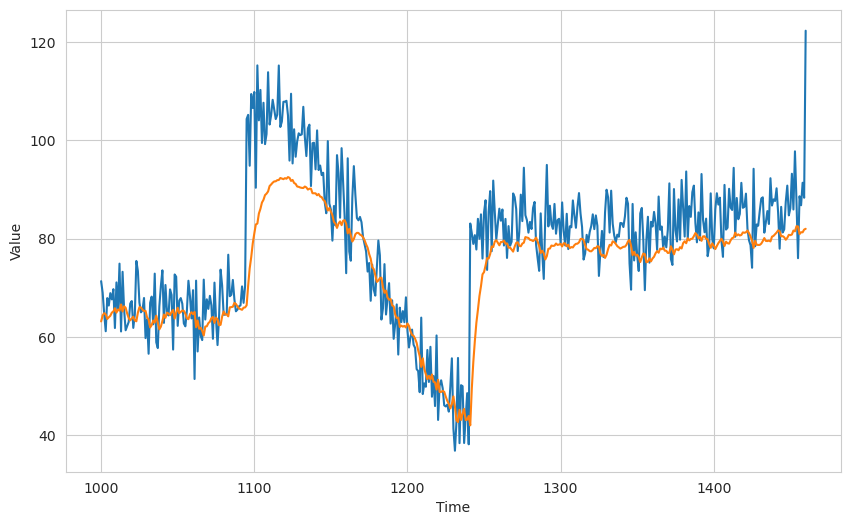

In [13]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then generate the metrics to evaluate the model's performance.

In [14]:
# Compute the MSE and MAE
print(metrics.mean_squared_error(x_valid, results).numpy())
print(metrics.mean_absolute_error(x_valid, results).numpy())

79.8183
6.4938865


## Wrap Up

This concludes this short exercise on using LSTMs for time series forecasting. Next week, you will build upon this and add convolutions. Then, you will start to move away from synthetic data and use real-world datasets. See you there!

## Optional: Including a Validation Set while Training

Back in the first course of this specialization, you saw how you can also monitor the performance of your model against a validation set while training. You can also do that for this lab.

First, you need to generate a `val_set` which are data windows and labels that your model can accept. You can simply reuse the `windowed_dataset` function for that and you can pass in the `x_valid` points to generate the windows.

In [15]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

You can then do the same training as before but pass in the `val_set` to the `validation_data` parameter of the `fit()` method.

In [16]:
# Reset states generated by Keras
backend.clear_session()

# Build the model
model = Sequential([Input(shape=(None,)),
                    layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
                    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
                    layers.Bidirectional(layers.LSTM(32)),
                    layers.Dense(1),
                    layers.Lambda(lambda x: x * 100.0)])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
     30/Unknown 3s 7ms/step - loss: 32.3811 - mae: 32.8795

2024-06-14 11:45:13.960213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:13.960254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 31.6811 - mae: 32.1794 - val_loss: 21.0265 - val_mae: 21.5244
Epoch 2/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9964 - mae: 10.4764  

2024-06-14 11:45:14.478692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:14.478742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.5629 - mae: 10.0437 - val_loss: 19.7159 - val_mae: 20.2131
Epoch 3/100


2024-06-14 11:45:14.839618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:14.840027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:14.956348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:14.956382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6447 - mae: 8.1305 - val_loss: 16.3533 - val_mae: 16.8502
Epoch 4/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 8.6995 - mae: 9.1918

2024-06-14 11:45:15.268695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:15.268738: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:15.268759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:15.353311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:15.353342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:15.353365: I tensorflow/core/framework/local_ren

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.7111 - mae: 8.1915 - val_loss: 13.1829 - val_mae: 13.6772
Epoch 5/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 7.6115 - mae: 8.0914

2024-06-14 11:45:15.662894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:15.662940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:15.750378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:15.750411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:15.750435: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17844289651246375207
2024-06-14 11:45:15.750445: I tensorflow/core/fram

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0201 - mae: 7.4990 - val_loss: 12.1143 - val_mae: 12.6075
Epoch 6/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 7.0551 - mae: 7.5378

2024-06-14 11:45:16.062763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:16.062808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:16.148672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:16.148706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:16.148718: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17844289651246375207
2024-06-14 11:45:16.148727: I tensorflow/core/fram

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.2402 - mae: 7.7258 - val_loss: 11.0150 - val_mae: 11.5070
Epoch 7/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 6.9304 - mae: 7.4051

2024-06-14 11:45:16.459434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:16.459465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:16.545445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:16.545478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8798 - mae: 7.3605 - val_loss: 10.4037 - val_mae: 10.8951
Epoch 8/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 5.8016 - mae: 6.2838

2024-06-14 11:45:16.885887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:16.885928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:16.971454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:16.971486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5435 - mae: 7.0279 - val_loss: 8.6029 - val_mae: 9.0876
Epoch 9/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.1526 - mae: 4.6477

2024-06-14 11:45:17.290068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:17.290139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:17.376664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:17.376700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1837 - mae: 6.6648 - val_loss: 8.7832 - val_mae: 9.2676
Epoch 10/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 9.9563 - mae: 10.4381

2024-06-14 11:45:17.688457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:17.688497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:17.773438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:17.773472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7375 - mae: 7.2213 - val_loss: 8.1332 - val_mae: 8.6217
Epoch 11/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.8852 - mae: 4.3671

2024-06-14 11:45:18.086043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:18.086086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:18.086117: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:18.086127: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 7666268923518072989
2024-06-14 11:45:18.086138: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:18.086146: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 7540776465848203

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2638 - mae: 6.7411 - val_loss: 8.5827 - val_mae: 9.0693
Epoch 12/100


2024-06-14 11:45:18.484126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:18.484160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:18.484172: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:18.484179: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:18.484187: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:18.605975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of s

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0562 - mae: 6.5385 - val_loss: 8.1338 - val_mae: 8.6209
Epoch 13/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 5.7698 - mae: 6.2337

2024-06-14 11:45:18.915984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:18.916014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:19.000960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:19.000993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0972 - mae: 6.5698 - val_loss: 7.9171 - val_mae: 8.4027
Epoch 14/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 2.9378 - mae: 3.4117

2024-06-14 11:45:19.312626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:19.312672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:19.398273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:19.398348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:19.398362: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17844289651246375207
2024-06-14 11:45:19.398380: I tensorflow/core/fram

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5065 - mae: 5.9861 - val_loss: 8.3171 - val_mae: 8.8025
Epoch 15/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 4.7909 - mae: 5.2471

2024-06-14 11:45:19.713237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:19.713283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:19.798157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:19.798224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9154 - mae: 6.3898 - val_loss: 7.3726 - val_mae: 7.8596
Epoch 16/100


2024-06-14 11:45:20.114169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:20.114207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:20.199937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:20.199973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1349 - mae: 6.6137 - val_loss: 7.5820 - val_mae: 8.0671
Epoch 17/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 5.7620 - mae: 6.2498

2024-06-14 11:45:20.573678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:20.573724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:20.659271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:20.659306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6659 - mae: 6.1444 - val_loss: 6.7069 - val_mae: 7.1948
Epoch 18/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4.7373 - mae: 5.2189

2024-06-14 11:45:20.971836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:20.971871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:20.971895: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:21.059110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:21.059144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:21.059171: I tensorflow/core/framework/local_ren

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6855 - mae: 6.1663 - val_loss: 7.0977 - val_mae: 7.5839
Epoch 19/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 4.5783 - mae: 5.0494

2024-06-14 11:45:21.379638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:21.379709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:21.467579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:21.467615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3096 - mae: 5.7900 - val_loss: 6.6370 - val_mae: 7.1218
Epoch 20/100


2024-06-14 11:45:21.780442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:21.780476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:21.780546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:21.874123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:21.874158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:21.874171: I tensorflow/core/framework/local_ren

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5674 - mae: 6.0441 - val_loss: 6.7255 - val_mae: 7.2072
Epoch 21/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 4.4552 - mae: 4.9437

2024-06-14 11:45:22.245632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:22.245704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:22.343401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:22.343435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3007 - mae: 5.7778 - val_loss: 7.5677 - val_mae: 8.0544
Epoch 22/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 7.2729 - mae: 7.7676

2024-06-14 11:45:22.660712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:22.660754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:22.748138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:22.748172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8549 - mae: 6.3349 - val_loss: 7.6341 - val_mae: 8.1200
Epoch 23/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.1765 - mae: 5.6526

2024-06-14 11:45:23.061373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:23.061430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:23.148662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:23.148697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2677 - mae: 5.7453 - val_loss: 6.7368 - val_mae: 7.2202
Epoch 24/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.2434 - mae: 4.7160

2024-06-14 11:45:23.459716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:23.459758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:23.459786: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:23.545788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:23.545828: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8291265403773941168
2024-06-14 11:45:23.545854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2868 - mae: 5.7654 - val_loss: 6.9296 - val_mae: 7.4119
Epoch 25/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.7974 - mae: 5.2816

2024-06-14 11:45:23.856271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:23.856329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:23.942256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:23.942290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:23.942302: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17844289651246375207
2024-06-14 11:45:23.942310: I tensorflow/core/fram

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0345 - mae: 5.5128 - val_loss: 8.2075 - val_mae: 8.6956
Epoch 26/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 7.6887 - mae: 8.1813

2024-06-14 11:45:24.292072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:24.292109: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:24.292119: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:24.292151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:24.377216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:24.377251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5862 - mae: 6.0648 - val_loss: 7.1468 - val_mae: 7.6300
Epoch 27/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 5.3776 - mae: 5.8563

2024-06-14 11:45:24.692505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:24.692540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:24.779342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:24.779376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5921 - mae: 6.0756 - val_loss: 6.3473 - val_mae: 6.8293
Epoch 28/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 6.0436 - mae: 6.5294

2024-06-14 11:45:25.092845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:25.092884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:25.178294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:25.178333: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8291265403773941168
2024-06-14 11:45:25.178362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2834 - mae: 5.7576 - val_loss: 7.6004 - val_mae: 8.0865
Epoch 29/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 7.5219 - mae: 8.0172

2024-06-14 11:45:25.493244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:25.493277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:25.577865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:25.577905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.4093 - mae: 5.8864 - val_loss: 6.9900 - val_mae: 7.4722
Epoch 30/100


2024-06-14 11:45:25.893340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:25.893380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_19]]
2024-06-14 11:45:25.893405: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:25.893464: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:25.893498: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:26.009366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is abortin

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0952 - mae: 5.5747 - val_loss: 6.3778 - val_mae: 6.8630
Epoch 31/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 4.8604 - mae: 5.3509

2024-06-14 11:45:26.330069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:26.330113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:26.417306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:26.417379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8466 - mae: 5.3286 - val_loss: 6.6611 - val_mae: 7.1422
Epoch 32/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.8744 - mae: 6.3394

2024-06-14 11:45:26.733784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:26.733823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:26.818354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:26.818431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1279 - mae: 5.6016 - val_loss: 7.0138 - val_mae: 7.4951
Epoch 33/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 3.3461 - mae: 3.8175

2024-06-14 11:45:27.137355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:27.137393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:27.137402: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:27.137430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:27.226002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:27.226040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6786 - mae: 5.1590 - val_loss: 5.9678 - val_mae: 6.4494
Epoch 34/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 5.7514 - mae: 6.2514

2024-06-14 11:45:27.542790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:27.542866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:27.628262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:27.628295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2579 - mae: 5.7430 - val_loss: 6.1348 - val_mae: 6.6162
Epoch 35/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.1678 - mae: 5.6248

2024-06-14 11:45:27.975688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:27.975724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:27.975737: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:27.975745: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:27.975754: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:28.060238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of s

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1687 - mae: 5.6433 - val_loss: 6.3969 - val_mae: 6.8836
Epoch 36/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4.0294 - mae: 4.5197

2024-06-14 11:45:28.372771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:28.372805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:28.459227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:28.459261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6466 - mae: 5.1276 - val_loss: 5.9324 - val_mae: 6.4141
Epoch 37/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4.4708 - mae: 4.9499

2024-06-14 11:45:28.777009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:28.777050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:28.863399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:28.863438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6196 - mae: 5.0962 - val_loss: 7.1901 - val_mae: 7.6735
Epoch 38/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.8729 - mae: 5.3478

2024-06-14 11:45:29.182388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:29.182428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:29.271535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:29.271572: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8291265403773941168
2024-06-14 11:45:29.271603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9615 - mae: 5.4403 - val_loss: 6.8351 - val_mae: 7.3159
Epoch 39/100


2024-06-14 11:45:29.587527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:29.587560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:29.712159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:29.712195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:29.712206: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17844289651246375207
2024-06-14 11:45:29.712215: I tensorflow/core/fram

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8096 - mae: 5.2904 - val_loss: 6.0464 - val_mae: 6.5274
Epoch 40/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.4935 - mae: 5.9536

2024-06-14 11:45:30.027204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:30.027261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:30.112403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:30.112438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2762 - mae: 5.7514 - val_loss: 6.1081 - val_mae: 6.5858
Epoch 41/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.0638 - mae: 4.5343

2024-06-14 11:45:30.428955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:30.428998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:30.516974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:30.517008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7375 - mae: 5.2155 - val_loss: 7.9254 - val_mae: 8.4150
Epoch 42/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 6.5086 - mae: 6.9901

2024-06-14 11:45:30.831919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:30.831957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:30.832025: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:30.920010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:30.920043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:30.920066: I tensorflow/core/framework/local_ren

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0227 - mae: 5.5002 - val_loss: 7.3356 - val_mae: 7.8201
Epoch 43/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 5.2632 - mae: 5.7289

2024-06-14 11:45:31.235814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:31.235849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:31.235872: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:31.235884: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:31.321730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:31.321758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9809 - mae: 5.4512 - val_loss: 6.2257 - val_mae: 6.7101
Epoch 44/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 5.4137 - mae: 5.8928

2024-06-14 11:45:31.672073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:31.672106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:31.672120: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:31.672127: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:31.672136: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:31.759141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of s

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6951 - mae: 5.1760 - val_loss: 7.4932 - val_mae: 7.9826
Epoch 45/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 5.2707 - mae: 5.7555

2024-06-14 11:45:32.093769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:32.093803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:32.093834: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:32.093872: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:32.178544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:32.178578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9383 - mae: 5.4190 - val_loss: 6.0413 - val_mae: 6.5194
Epoch 46/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.2839 - mae: 4.7667

2024-06-14 11:45:32.498947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:32.498988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:32.584529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:32.584565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4448 - mae: 4.9182 - val_loss: 6.1118 - val_mae: 6.5919
Epoch 47/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 3.5459 - mae: 4.0345

2024-06-14 11:45:32.898479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:32.898529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:32.984546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:32.984584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:32.984611: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8291265403773941168


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5511 - mae: 5.0309 - val_loss: 5.8449 - val_mae: 6.3282
Epoch 48/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.9911 - mae: 5.4897

2024-06-14 11:45:33.333367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:33.333419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:33.418276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:33.418311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7348 - mae: 5.2148 - val_loss: 5.8533 - val_mae: 6.3364
Epoch 49/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.0089 - mae: 5.4761

2024-06-14 11:45:33.731366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:33.731427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:33.816000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:33.816037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8216 - mae: 5.2983 - val_loss: 6.7817 - val_mae: 7.2594
Epoch 50/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 6.0082 - mae: 6.4859

2024-06-14 11:45:34.127838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:34.127937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:34.212807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:34.212879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8669 - mae: 5.3414 - val_loss: 5.8115 - val_mae: 6.2944
Epoch 51/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 4.4407 - mae: 4.9372

2024-06-14 11:45:34.526061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:34.526129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:34.610906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:34.610945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7816 - mae: 5.2578 - val_loss: 5.9846 - val_mae: 6.4653
Epoch 52/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 3.5808 - mae: 4.0564

2024-06-14 11:45:34.964814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:34.964849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_19]]
2024-06-14 11:45:34.964875: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:34.964888: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:34.964904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:35.048618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is abortin

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5374 - mae: 5.0124 - val_loss: 6.4196 - val_mae: 6.8992
Epoch 53/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 3.1869 - mae: 3.6660

2024-06-14 11:45:35.363202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:35.363231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:35.448189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:35.448222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]
2024-06-14 11:45:35.448251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8291265403773941168
2024-06-14 11:45:35.448264: I tensorflow/core/framework/local

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4837 - mae: 4.9616 - val_loss: 5.7508 - val_mae: 6.2323
Epoch 54/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.1861 - mae: 5.6616

2024-06-14 11:45:35.764044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:35.764079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:35.764091: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:35.764098: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:35.764106: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:35.852042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of s

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4758 - mae: 4.9502 - val_loss: 6.1583 - val_mae: 6.6385
Epoch 55/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.5198 - mae: 4.9721

2024-06-14 11:45:36.163652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:36.163689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:36.247341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:36.247380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5205 - mae: 4.9975 - val_loss: 6.6025 - val_mae: 7.0808
Epoch 56/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 3.6135 - mae: 4.0897

2024-06-14 11:45:36.608609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:36.608643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:36.608655: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:36.608662: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:36.608671: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:36.693022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of s

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3579 - mae: 4.8314 - val_loss: 5.5143 - val_mae: 5.9886
Epoch 57/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.1882 - mae: 4.6684

2024-06-14 11:45:37.010422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:37.010460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:37.010487: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:37.099661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:37.099709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8291265403773941168
2024-06-14 11:45:37.099732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7688 - mae: 5.2460 - val_loss: 5.6803 - val_mae: 6.1632
Epoch 58/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 3.9641 - mae: 4.4222

2024-06-14 11:45:37.421425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:37.421460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:37.508860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:37.508931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7041 - mae: 5.1790 - val_loss: 5.8008 - val_mae: 6.2804
Epoch 59/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.6580 - mae: 5.1391

2024-06-14 11:45:37.831007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:37.831039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:37.921429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:37.921498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7639 - mae: 5.2454 - val_loss: 5.9440 - val_mae: 6.4245
Epoch 60/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 4.1907 - mae: 4.6703

2024-06-14 11:45:38.276741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:38.276795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:38.360302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:38.360335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5198 - mae: 4.9948 - val_loss: 6.1535 - val_mae: 6.6352
Epoch 61/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 5.0477 - mae: 5.4991

2024-06-14 11:45:38.673331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:38.673365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_19]]
2024-06-14 11:45:38.673391: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:38.673400: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:38.673434: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:38.759193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is abortin

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6350 - mae: 5.1109 - val_loss: 5.5062 - val_mae: 5.9905
Epoch 62/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4.6173 - mae: 5.0701

2024-06-14 11:45:39.079542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:39.079578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:39.167470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:39.167515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:39.167530: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17844289651246375207
2024-06-14 11:45:39.167539: I tensorflow/core/fram

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4785 - mae: 4.9498 - val_loss: 5.5174 - val_mae: 6.0025
Epoch 63/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 4.0548 - mae: 4.5428

2024-06-14 11:45:39.482925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:39.482960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:39.572582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:39.572618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4396 - mae: 4.9189 - val_loss: 6.3914 - val_mae: 6.8699
Epoch 64/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 3.5613 - mae: 4.0374

2024-06-14 11:45:39.925052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:39.925087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:40.010398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:40.010433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:40.010458: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8291265403773941168


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3733 - mae: 4.8479 - val_loss: 6.5023 - val_mae: 6.9808
Epoch 65/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 5.2666 - mae: 5.7631

2024-06-14 11:45:40.328049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:40.328087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:40.414541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:40.414580: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8291265403773941168
2024-06-14 11:45:40.414626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6703 - mae: 5.1517 - val_loss: 5.5808 - val_mae: 6.0641
Epoch 66/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.2768 - mae: 4.7564

2024-06-14 11:45:40.735763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:40.735817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:40.823828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:40.823860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4158 - mae: 4.8936 - val_loss: 6.2725 - val_mae: 6.7514
Epoch 67/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 5.4141 - mae: 5.8773

2024-06-14 11:45:41.149458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:41.149498: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:41.149507: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:41.149529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:41.237944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:41.237978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3742 - mae: 4.8506 - val_loss: 5.6003 - val_mae: 6.0825
Epoch 68/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 5.1014 - mae: 5.5683

2024-06-14 11:45:41.591555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:41.591633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:41.677038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:41.677072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3856 - mae: 4.8623 - val_loss: 6.3573 - val_mae: 6.8362
Epoch 69/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4.6728 - mae: 5.1623

2024-06-14 11:45:41.993560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:41.993658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:42.087234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:42.087263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4217 - mae: 4.8981 - val_loss: 5.7475 - val_mae: 6.2311
Epoch 70/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 4.3273 - mae: 4.8091

2024-06-14 11:45:42.406048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:42.406087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:42.492249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:42.492283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2867 - mae: 4.7670 - val_loss: 5.8218 - val_mae: 6.3034
Epoch 71/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.2592 - mae: 4.7477

2024-06-14 11:45:42.810689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:42.810737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:42.898200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:42.898239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]
2024-06-14 11:45:42.898279: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8291265403773941168
2024-06-14 11:45:42.898297: I tensorflow/core/framework/local

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4895 - mae: 4.9658 - val_loss: 6.1110 - val_mae: 6.5896
Epoch 72/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 3.6053 - mae: 4.0706

2024-06-14 11:45:43.242285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:43.242323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:43.328518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:43.328551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]
2024-06-14 11:45:43.328574: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8291265403773941168
2024-06-14 11:45:43.328585: I tensorflow/core/framework/local

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4931 - mae: 4.9709 - val_loss: 6.0797 - val_mae: 6.5571
Epoch 73/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 4.5061 - mae: 4.9987

2024-06-14 11:45:43.647441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:43.647475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:43.647488: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:43.647504: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:43.647518: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:43.733898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of s

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4661 - mae: 4.9459 - val_loss: 5.9753 - val_mae: 6.4517
Epoch 74/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 4.2419 - mae: 4.7419

2024-06-14 11:45:44.050861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:44.050896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:44.050966: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:44.139169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:44.139201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6479 - mae: 5.1269 - val_loss: 6.3027 - val_mae: 6.7829
Epoch 75/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.8157 - mae: 4.2697

2024-06-14 11:45:44.462073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:44.462112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:44.550152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:44.550187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5686 - mae: 5.0464 - val_loss: 5.8478 - val_mae: 6.3291
Epoch 76/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4.1618 - mae: 4.6323

2024-06-14 11:45:44.910339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:44.910391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:44.996795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]
2024-06-14 11:45:44.996831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:44.996855: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8291265403773941168
2024-06-14 11:45:44.996866: I tensorflow/core/framework/local

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4498 - mae: 4.9278 - val_loss: 5.7252 - val_mae: 6.2102
Epoch 77/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 4.5624 - mae: 5.0596

2024-06-14 11:45:45.321469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:45.321549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:45.407069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:45.407104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2445 - mae: 4.7183 - val_loss: 6.4126 - val_mae: 6.8915
Epoch 78/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.6160 - mae: 4.0928

2024-06-14 11:45:45.727862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:45.727908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:45.812181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:45.812218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5246 - mae: 4.9999 - val_loss: 6.6500 - val_mae: 7.1269
Epoch 79/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 2.9715 - mae: 3.4636

2024-06-14 11:45:46.130173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:46.130204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:46.216481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:46.216521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0971 - mae: 4.5739 - val_loss: 5.6145 - val_mae: 6.0978
Epoch 80/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 6.1746 - mae: 6.6694

2024-06-14 11:45:46.575268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:46.575309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:46.661351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:46.661389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7342 - mae: 5.2145 - val_loss: 7.0619 - val_mae: 7.5490
Epoch 81/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 5.9830 - mae: 6.4583

2024-06-14 11:45:46.973276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:46.973318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:47.062393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:47.062431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4665 - mae: 4.9408 - val_loss: 6.8711 - val_mae: 7.3522
Epoch 82/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 4.4211 - mae: 4.8920

2024-06-14 11:45:47.382929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:47.382974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:47.470420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:47.470454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3922 - mae: 4.8694 - val_loss: 6.0257 - val_mae: 6.5031
Epoch 83/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.8112 - mae: 5.2823

2024-06-14 11:45:47.787715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:47.787753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:47.787782: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:47.787821: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:47.872340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:47.872372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4851 - mae: 4.9621 - val_loss: 5.9256 - val_mae: 6.4030
Epoch 84/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.4982 - mae: 4.9793

2024-06-14 11:45:48.222364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:48.222429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:48.308317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:48.308354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4814 - mae: 4.9611 - val_loss: 7.4341 - val_mae: 7.9258
Epoch 85/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 3.4158 - mae: 3.9014

2024-06-14 11:45:48.620979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:48.621013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:48.621038: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:48.621082: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:48.708313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:48.708348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7403 - mae: 5.2199 - val_loss: 8.4867 - val_mae: 8.9813
Epoch 86/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 7.0227 - mae: 7.5201

2024-06-14 11:45:49.037257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:49.037292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:49.037305: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:49.037312: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:49.037320: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:49.122736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of s

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7407 - mae: 5.2233 - val_loss: 5.5883 - val_mae: 6.0719
Epoch 87/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.3406 - mae: 3.8356

2024-06-14 11:45:49.439060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:49.439118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:49.524208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:49.524280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3138 - mae: 4.7926 - val_loss: 6.1353 - val_mae: 6.6138
Epoch 88/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 2.5768 - mae: 3.0419

2024-06-14 11:45:49.877894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:49.877959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:49.961543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:49.961575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1583 - mae: 4.6384 - val_loss: 6.3482 - val_mae: 6.8275
Epoch 89/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 5.3003 - mae: 5.7772

2024-06-14 11:45:50.280144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:50.280181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:50.368297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:50.368384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4251 - mae: 4.9023 - val_loss: 5.6704 - val_mae: 6.1551
Epoch 90/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 3.6564 - mae: 4.1504

2024-06-14 11:45:50.686847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:50.686882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:50.772746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:50.772780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1671 - mae: 4.6461 - val_loss: 5.4107 - val_mae: 5.8948
Epoch 91/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 5.8981 - mae: 6.3782

2024-06-14 11:45:51.087877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:51.087913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:51.174353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:51.174387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8508 - mae: 5.3288 - val_loss: 5.3724 - val_mae: 5.8554
Epoch 92/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 5.2002 - mae: 5.6548

2024-06-14 11:45:51.544571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:51.544605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:51.544619: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:51.544627: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:51.544636: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:51.628997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of s

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7503 - mae: 5.2217 - val_loss: 5.7417 - val_mae: 6.2243
Epoch 93/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 5.0152 - mae: 5.5152

2024-06-14 11:45:51.946990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:51.947033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:52.039436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:52.039468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4541 - mae: 4.9316 - val_loss: 6.4145 - val_mae: 6.8928
Epoch 94/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 6.5967 - mae: 7.0930

2024-06-14 11:45:52.367009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:52.367056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:52.454070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:52.454103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:52.454126: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8291265403773941168


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5688 - mae: 5.0479 - val_loss: 5.7677 - val_mae: 6.2496
Epoch 95/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 2.9504 - mae: 3.4139

2024-06-14 11:45:52.781363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:52.781451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:52.865949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:52.865984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2148 - mae: 4.6936 - val_loss: 7.7586 - val_mae: 8.2447
Epoch 96/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4.5822 - mae: 5.0391

2024-06-14 11:45:53.215883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:53.215918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:45:53.215943: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:53.215986: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:53.300499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:53.300533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5655 - mae: 5.0376 - val_loss: 5.7827 - val_mae: 6.2636
Epoch 97/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 6.1532 - mae: 6.6208

2024-06-14 11:45:53.617269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:53.617321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:53.703906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:53.703944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6146 - mae: 5.0896 - val_loss: 5.6013 - val_mae: 6.0869
Epoch 98/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 3.5396 - mae: 3.9605

2024-06-14 11:45:54.021142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:54.021174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:54.105322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:54.105357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4006 - mae: 4.8706 - val_loss: 6.5034 - val_mae: 6.9807
Epoch 99/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.1655 - mae: 4.6553

2024-06-14 11:45:54.425777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:54.425811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_19]]
2024-06-14 11:45:54.425837: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5188398389191876815
2024-06-14 11:45:54.425845: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10268762017519382265
2024-06-14 11:45:54.425880: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8376820538907078272
2024-06-14 11:45:54.514065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is abortin

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2554 - mae: 4.7385 - val_loss: 6.2697 - val_mae: 6.7481
Epoch 100/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4.4710 - mae: 4.9423

2024-06-14 11:45:54.866555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:54.866596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:54.951714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:54.951748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:45:54.951761: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17844289651246375207
2024-06-14 11:45:54.951770: I tensorflow/core/fram

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5692 - mae: 5.0487 - val_loss: 5.9079 - val_mae: 6.3838


2024-06-14 11:45:55.270101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:55.270190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 11:45:55.357319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:45:55.357355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
